In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'pandas'

<b><h3>Data Cleaning

In [3]:
pima_df = pd.read_csv("diabetes.csv")
pima_df["Outcome"] = pima_df["Outcome"].apply(lambda x:-1 if x == 0 else 1)
pima_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,-1
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,-1
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
pima_df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [5]:
len(pima_df)

768

<b><h3>Split dataset into training and testing examples and normalize the values

In [6]:
columns = list(pima_df.columns)
columns

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Outcome']

In [7]:
X = pima_df[['Glucose', 'BMI']].values.astype(np.float32)
y = pima_df['Outcome'].values.astype(np.int32)

np.random.seed(535)
random_idx = np.random.permutation(len(y))

train_size = int(0.7 * len(random_idx))
train_idx = random_idx[:train_size]
test_idx = random_idx[train_size:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

mu = np.mean(X_train, axis=0)
sigma = np.std(X_train, axis=0)

# Use the mean and std to normalize
X_train = (X_train - mu) / sigma
X_test = (X_test - mu) / sigma

<b><h3>Visualize the binary class without classification.

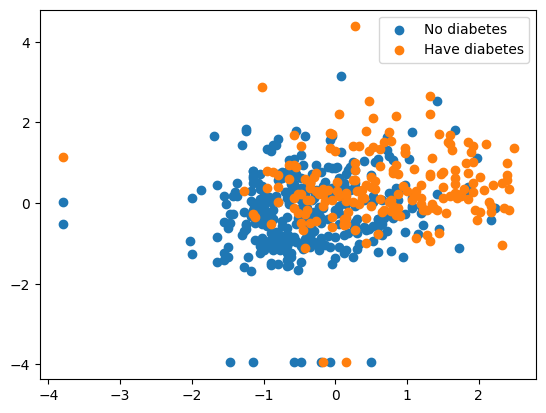

In [8]:
plt.scatter(X_train[y_train == -1, 0], X_train[y_train == -1, 1], label='No diabetes')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], label='Have diabetes')
plt.legend()
plt.show()


<b><h3>As we can see, the dataset can not be linearly separated. Hence, Hard-SVM is not useful. In this case, we could use Soft-SVM to allow the constraint to be violated for some of the examples in the training set.

<b><h1> Implementation

Objective function:


$$
\begin{align}
\min_{\mathbf{w}} \left( \frac{\lambda}{2} \|\mathbf{w}\|^2 + \frac{1}{m} \sum_{i=1}^{m} \max\{0, 1 - y_i (\langle \mathbf{w}, \mathbf{x}_i \rangle+b) \} \right)
\end{align}
$$



\begin{align}
L = \frac{\lambda}{2} ||\mathbf{w}||^2 + \frac{1}{m} \sum_{i=1}^{m} \max\{0, 1 - y_i(\langle \mathbf{w}, \mathbf{x}_i \rangle + b)\}
\end{align}

\begin{align}
\frac{\partial L}{\partial \mathbf{w}} =
\begin{cases}
\lambda \mathbf{w} - y_i \mathbf{x}_i & \text{if } 1 - y_i(\langle \mathbf{w}, \mathbf{x}_i \rangle + b) > 0 \\
\lambda \mathbf{w} & \text{if } 1 - y_i(\langle \mathbf{w}, \mathbf{x}_i \rangle + b) \leq 0
\end{cases}
\end{align}

\begin{align}
\frac{\partial L}{\partial b} =
\begin{cases}
-y_i & \text{if } 1 - y_i(\langle \mathbf{w}, \mathbf{x}_i \rangle + b) > 0 \\
0 & \text{if } 1 - y_i(\langle \mathbf{w}, \mathbf{x}_i \rangle + b) \leq 0
\end{cases}
\end{align}


In [9]:
class softsvm():
  def __init__(self, num_features,lambda_val):
    self.weights = np.zeros(num_features)
    self.bias = np.zeros(1)
    self.lab = lambda_val


  # Prediction
  def forward(self, x):
      netinputs = np.dot(x,self.weights) + self.bias
      prediction = np.sign(netinputs)
      return prediction

  # Backpropagation to get the gradient with respect to w and b
  def backward(self, x, y):
    if y * (np.dot(x,self.weights)+self.bias) <1:
      grad_w = self.lab * self.weights - y*x
      grad_b = -y
    else:
      grad_w = self.lab * self.weights
      grad_b = 0
    return grad_w, grad_b



In [10]:
def loss_func(x,y,val_lambda,weights,bias):
    reg_term = 0.5 * val_lambda * (np.linalg.norm(weights)**2)
    signed_dis = 1-y * (np.dot(x,weights)+bias)
    hinge_loss = np.mean(np.maximum(0,signed_dis))
    return reg_term + hinge_loss

# Training
def train(model,x,y,epoch,learning_rate):
  cost = []
  for e in range(epoch):
    for i in range(len(y)):
      grad_w, grad_b = model.backward(x[i],y[i])
      model.weights -= learning_rate * grad_w
      model.bias -= learning_rate * grad_b
    loss = loss_func(x,y,model.lab,model.weights,model.bias)
    print('Epoch: %03d' % (e+1), end="")
    print('| Loss: %.5f' % loss)
    cost.append(loss)
  return cost

In [11]:
epoch = 200
lr_rate = 0.0001
lambda_val = 0.001
model = softsvm(X_train.shape[1],lambda_val)
loss = train(model,X_train,y_train,epoch, lr_rate)

Epoch: 001| Loss: 0.97945
Epoch: 002| Loss: 0.95891
Epoch: 003| Loss: 0.93837
Epoch: 004| Loss: 0.91783
Epoch: 005| Loss: 0.89729
Epoch: 006| Loss: 0.87675
Epoch: 007| Loss: 0.85622
Epoch: 008| Loss: 0.83568
Epoch: 009| Loss: 0.81553
Epoch: 010| Loss: 0.79632
Epoch: 011| Loss: 0.77744
Epoch: 012| Loss: 0.75917
Epoch: 013| Loss: 0.74171
Epoch: 014| Loss: 0.72508
Epoch: 015| Loss: 0.70962
Epoch: 016| Loss: 0.69462
Epoch: 017| Loss: 0.68009
Epoch: 018| Loss: 0.66688
Epoch: 019| Loss: 0.65503
Epoch: 020| Loss: 0.64462
Epoch: 021| Loss: 0.63570
Epoch: 022| Loss: 0.62767
Epoch: 023| Loss: 0.62088
Epoch: 024| Loss: 0.61494
Epoch: 025| Loss: 0.60990
Epoch: 026| Loss: 0.60532
Epoch: 027| Loss: 0.60129
Epoch: 028| Loss: 0.59777
Epoch: 029| Loss: 0.59461
Epoch: 030| Loss: 0.59202
Epoch: 031| Loss: 0.58957
Epoch: 032| Loss: 0.58734
Epoch: 033| Loss: 0.58535
Epoch: 034| Loss: 0.58342
Epoch: 035| Loss: 0.58160
Epoch: 036| Loss: 0.57981
Epoch: 037| Loss: 0.57806
Epoch: 038| Loss: 0.57645
Epoch: 039| 

<b><h3> Visualize the loss

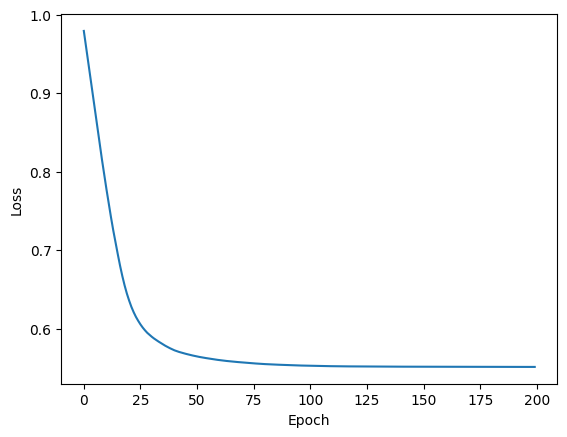

In [12]:
plt.plot(range(epoch), loss)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [13]:
model.weights, model.bias

(array([0.8948309 , 0.41464464]), array([-0.6517]))

<b><h3> Training and Testing accuracy

In [14]:
train_pred = model.forward(X_train)
train_acc = np.mean(train_pred == y_train)

test_pred = model.forward(X_test)
test_acc = np.mean(test_pred == y_test)

print('Training Accuracy: %.2f' % (train_acc*100))
print('Test Accuracy: %.2f' % (test_acc*100))

Training Accuracy: 76.91
Test Accuracy: 77.49


<b><h3> Draw the decision boundary (i.e. hyperplane)

Left plot is the visualization of training set. Right plot is the visualization of testing set.

**Hyperplane**:
$$
\begin{align}
w_1x_1 + w_2x_2 + b = 0
\end{align}
$$
**Positive margin**:
$$
\begin{align}
w_1x_1 + w_2x_2 + b = 1
\end{align}
$$

**Negative margin**:
$$
\begin{align}
w_1x_1 + w_2x_2 + b = -1
\end{align}
$$

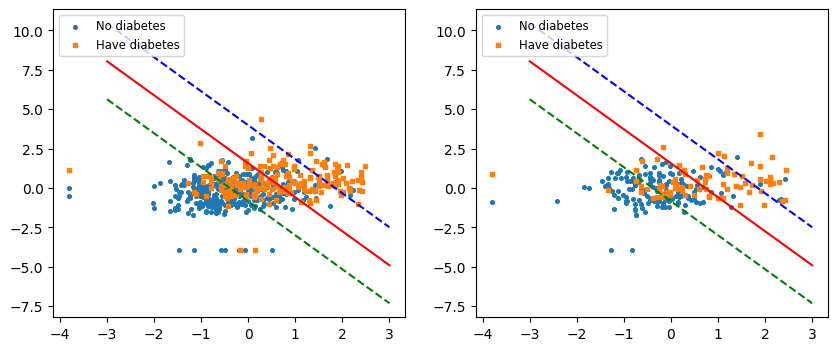

In [15]:
w, b = model.weights, model.bias

x_min = -3
y_min = ( (-(w[0] * x_min) - b[0])
          / w[1] )

x_max = 3
y_max = ( (-(w[0] * x_max) - b[0])
          / w[1] )


fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
ax[0].plot([x_min, x_max], [y_min, y_max],c = "r")
ax[1].plot([x_min, x_max], [y_min, y_max], c = "r")

ax[0].scatter(X_train[y_train==-1, 0], X_train[y_train==-1, 1], label='No diabetes', marker='o',s = 7)
ax[0].scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], label='Have diabetes', marker='s',s =7)

ax[1].scatter(X_test[y_test==-1, 0], X_test[y_test==-1, 1], label='No diabetes', marker='o',s = 7)
ax[1].scatter(X_test[y_test==1, 0], X_test[y_test==1, 1], label='Have diabetes', marker='s',s = 7)

ax[0].legend(loc='upper left',fontsize = "small")
ax[1].legend(loc='upper left',fontsize = "small")

# Margin for training samples
y_min_margin = ((-(w[0] * x_min) - b[0] + 1) / w[1])
y_max_margin = ((-(w[0] * x_max) - b[0] + 1) / w[1])
ax[0].plot([x_min, x_max], [y_min_margin, y_max_margin], 'b--')

y_min_margin = ((-(w[0] * x_min) - b[0] - 1) / w[1])
y_max_margin = ((-(w[0] * x_max) - b[0] - 1) / w[1])
ax[0].plot([x_min, x_max], [y_min_margin, y_max_margin], "g--")


# Margin for testing samples
y_min_margin = ((-(w[0] * x_min) - b[0] + 1) / w[1])
y_max_margin = ((-(w[0] * x_max) - b[0] + 1) / w[1])
ax[1].plot([x_min, x_max], [y_min_margin, y_max_margin], 'b--')

y_min_margin = ((-(w[0] * x_min) - b[0] - 1) / w[1])
y_max_margin = ((-(w[0] * x_max) - b[0] - 1) / w[1])
ax[1].plot([x_min, x_max], [y_min_margin, y_max_margin], 'g--')

plt.show()

<b><h3> Conclusion: Based on the plot, we could see that Soft Margin SVM allows some misclassifications. Furthermore, since the original dataset is not linearly separable, it is hard to find a hyperplane that perfectly classify two classes. And the dataset only have 768 samples which is quite small. It may be the potential issues that cause lower prediction accuracies.

<b><h3> Choice of Learning rate: We try some larger learning rate which cause the overshooting and the convergence behavior is noisy. Hence, we select a quite small learning rate. With a number of epochs, the total loss converges to a fix number.

<b><h3> Choice of lambda: In Soft Margin SVM, larger lambda means more allowance of misclassifications and the margin will be larger. However, smaller lambda means smaller margin and potentially have fewer misclassifications